In [1]:
from getpass import getuser # Libaray to copy things
from tempfile import NamedTemporaryFile, TemporaryDirectory 

import dask

from dask.distributed import Client
import multiprocessing

ncpu = multiprocessing.cpu_count()
threads = 8
nworker = ncpu // threads
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}"
)
client = Client(
    processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit="100GB"
)
client 

# calculation
import metpy.calc as mpcalc

# scipy
from scipy import stats
from scipy.ndimage import measurements
from scipy import ndimage
from scipy.optimize import curve_fit

# for plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# basic
from pathlib import Path # Object oriented libary to deal with paths
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
import netCDF4 as nc
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data

# dask
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

Number of CPUs: 256, number of threads: 8, number of workers: 32


2024-12-06 16:17:20,946 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-g8sk4u7k', purging


In [2]:
import sys
sys.path.append('/home/m/m300948/ICON_AMZDEF')
import Tools

Number of CPUs: 256, number of threads: 8, number of workers: 32


# Load temperature data

In [10]:
path = '/work/uc1275/LukasBrunner/data/4Arim/old'
# Daily maximmum near surface air temper (tasmax)
tasmax_ctl = xr.open_dataset(f'{path}/tasmax_ctl.nc')['tas'].sel(time=slice('2022-01-01','2022-12-31'))
tasmax_def = xr.open_dataset(f'{path}/tasmax_def.nc')['tas'].sel(time=slice('2022-01-01','2022-12-31'))

In [11]:
# SH
sh_ctl = xr.open_dataset(f'{path}/sh_ctl.nc')['hus'].sel(time=slice('2022-01-01','2022-12-31'))
sh_def = xr.open_dataset(f'{path}/sh_def.nc')['hus'].sel(time=slice('2022-01-01','2022-12-31'))

In [12]:
# 1. Apparent temperature (AT) 
at_ctl = xr.open_dataset(f'{path}/at_ctl.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))
at_def = xr.open_dataset(f'{path}/at_def.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))

In [13]:
# 2. NOWW Heat Index (HI)
hi_ctl = xr.open_dataset(f'{path}/hi_ctl.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))
hi_def = xr.open_dataset(f'{path}/hi_def.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))

In [14]:
# 3. HUMIDEX
humidex_ctl = xr.open_dataset(f'{path}/humidex_ctl.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))
humidex_def = xr.open_dataset(f'{path}/humidex_def.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))

In [15]:
# 4. Simplified WBGT (SWBGT)
swbgt_ctl = xr.open_dataset(f'{path}/swbgt_ctl.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))
swbgt_def = xr.open_dataset(f'{path}/swbgt_def.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))

In [16]:
# 5. WBGT
wbgt_ctl = xr.open_dataset(f'{path}/wbgt_ctl.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))
wbgt_def = xr.open_dataset(f'{path}/wbgt_def.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))

In [17]:
# 6. WBT
wbt_ctl = xr.open_dataset(f'{path}/wbt_ctl.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))
wbt_def = xr.open_dataset(f'{path}/wbt_def.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))

In [18]:
# 7. Universal thermal climate index (UTCI)
utci_ctl = xr.open_dataset(f'{path}/utci_ctl.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))
utci_def = xr.open_dataset(f'{path}/utci_def.nc')['__xarray_dataarray_variable__'].sel(time=slice('2022-01-01','2022-12-31'))

### Masking

In [19]:
dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
AMZ_BD = dset_bd.AMAZON_BIOMES

In [20]:
ABinterp_biome = AMZ_BD.interp(latitude=tasmax_ctl.lat, longitude=tasmax_ctl.lon)

In [21]:
# tasmax
tasmax_ctl_mask = tasmax_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
tasmax_def_mask = tasmax_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [22]:
at_ctl_mask = at_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
at_def_mask = at_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [23]:
hi_ctl_mask = hi_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
hi_def_mask = hi_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [24]:
humidex_ctl_mask = humidex_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
humidex_def_mask = humidex_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [25]:
swbgt_ctl_mask = swbgt_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
swbgt_def_mask = swbgt_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [26]:
wbgt_ctl_mask = wbgt_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
wbgt_def_mask = wbgt_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [27]:
wbt_ctl_mask = wbt_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
wbt_def_mask = wbt_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [28]:
utci_ctl_mask = utci_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
utci_def_mask = utci_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

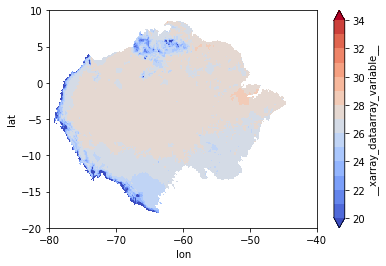

In [48]:
wbgt_def_mask.mean(dim='time').plot(levels=np.arange(20,35,1), cmap='coolwarm', extend='both')

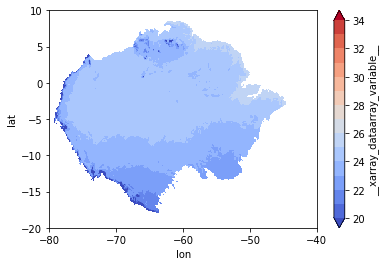

In [50]:
wbt_def_mask.mean(dim='time').plot(levels=np.arange(20,35,1), cmap='coolwarm', extend='both')

## Flattens

In [29]:
xarray_names = ['tasmax_ctl_mask','tasmax_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [30]:
xarray_names = ['at_ctl_mask','at_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [31]:
xarray_names = ['hi_ctl_mask','hi_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [32]:
xarray_names = ['humidex_ctl_mask','humidex_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [33]:
xarray_names = ['swbgt_ctl_mask','swbgt_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [35]:
xarray_names = ['wbgt_ctl_mask','wbgt_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [36]:
xarray_names = ['wbt_ctl_mask','wbt_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [34]:
xarray_names = ['utci_ctl_mask','utci_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [24]:
utci_ctl_mask_f

array([29.14509964, 28.53451767, 28.29004477, ..., 29.19151068,
       28.75372408, 30.07427114])

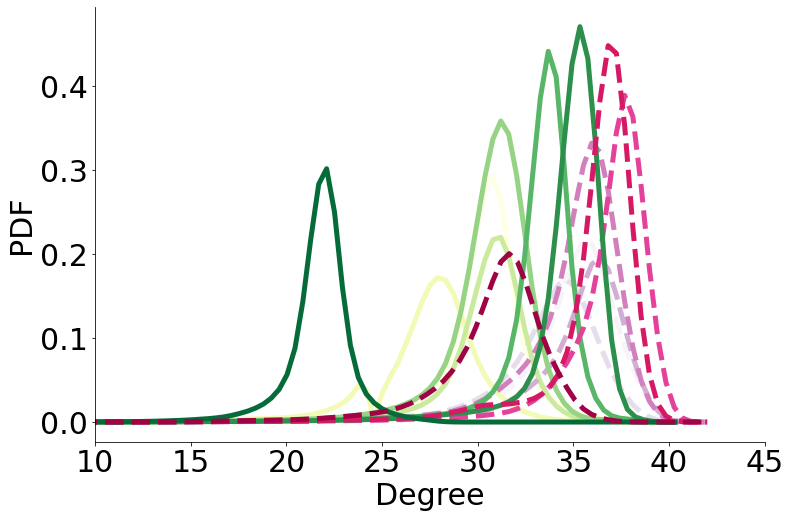

In [60]:
bins = 100
# TASMAX
#pdf_tasmax_ctl, bins_tasmax_ctl = np.histogram(tasmax_ctl_mask_f, bins=bins, density=True)  # Adjust the number of bins as needed
#pdf_tasmax_def, bins_tasmax_def = np.histogram(tasmax_def_mask_f, bins=bins, density=True)
# AT
pdf_at_ctl, bins_at_ctl = np.histogram(at_ctl_mask_f, bins=bins, density=True)  # Adjust the number of bins as needed
pdf_at_def, bins_at_def = np.histogram(at_def_mask_f, bins=bins, density=True)
# HI
pdf_hi_ctl, bins_hi_ctl = np.histogram(hi_ctl_mask_f, bins=bins, density=True)  # Adjust the number of bins as needed
pdf_hi_def, bins_hi_def = np.histogram(hi_def_mask_f, bins=bins, density=True)
# HUMIDEX
pdf_humidex_ctl, bins_humidex_ctl = np.histogram(humidex_ctl_mask_f, bins=bins, density=True)  # Adjust the number of bins as needed
pdf_humidex_def, bins_humidex_def = np.histogram(humidex_def_mask_f, bins=bins, density=True)
# SWBGT
pdf_swbgt_ctl, bins_swbgt_ctl = np.histogram(swbgt_ctl_mask_f, bins=bins, density=True)  # Adjust the number of bins as needed
pdf_swbgt_def, bins_swbgt_def = np.histogram(swbgt_def_mask_f, bins=bins, density=True)
# WBGT
pdf_wbgt_ctl, bins_wbgt_ctl = np.histogram(wbgt_ctl_mask_f, bins=bins, density=True)  # Adjust the number of bins as needed
pdf_wbgt_def, bins_wbgt_def = np.histogram(wbgt_def_mask_f, bins=bins, density=True)
# WBT
pdf_wbt_ctl, bins_wbt_ctl = np.histogram(wbt_ctl_mask_f, bins=bins, density=True)  # Adjust the number of bins as needed
pdf_wbt_def, bins_wbt_def = np.histogram(wbt_def_mask_f, bins=bins, density=True)
# UTCI
pdf_utci_ctl, bins_utci_ctl = np.histogram(utci_ctl_mask_f, bins=bins, density=True)  # Adjust the number of bins as needed
pdf_utci_def, bins_utci_def = np.histogram(utci_def_mask_f, bins=bins, density=True)

# Calculate the bin centers
bin_centers_ctl = (bins_at_ctl[:-1] + bins_at_ctl[1:]) / 2
bin_centers_def = (bins_at_def[:-1] + bins_at_def[1:]) / 2

# Calculate the bin width
bin_width_ctl = np.diff(bin_centers_ctl)
bin_width_def = np.diff(bin_centers_def)

left = matplotlib.cm.get_cmap('PuRd')
right = matplotlib.cm.get_cmap('YlGn')

colors_ctl = [right(i / 7) for i in range(7)]
colors_def = [left(i / 7) for i in range(7)]

# Plot the PDF
fig, ax = plt.subplots(figsize=(12,8))
#TASMAX
#plt.plot(bin_centers_ctl, pdf_tasmax_ctl, label='TASMAX CTL', color=right, linewidth=5)
#plt.plot(bin_centers_def, pdf_tasmax_def, label='TASMAX DEF', color=left, linewidth=5, ls='--')

plt.plot(bin_centers_ctl, pdf_at_ctl, label='AT CTL', color=colors_ctl[0], linewidth=5)
plt.plot(bin_centers_def, pdf_at_def, label='AT DEF', color=colors_def[0], linewidth=5, ls='--')

plt.plot(bin_centers_ctl, pdf_hi_ctl, label='HI CTL', color=colors_ctl[1], linewidth=5)
plt.plot(bin_centers_def, pdf_hi_def, label='HI DEF', color=colors_def[1], linewidth=5, ls='--')

plt.plot(bin_centers_ctl, pdf_humidex_ctl, label='HUMIDEX CTL', color=colors_ctl[2], linewidth=5)
plt.plot(bin_centers_def, pdf_humidex_def, label='HUMIDEX DEF', color=colors_def[2], linewidth=5, ls='--')

plt.plot(bin_centers_ctl, pdf_swbgt_ctl, label='SWBGT CTL', color=colors_ctl[3], linewidth=5)
plt.plot(bin_centers_def, pdf_swbgt_def, label='SWBGT DEF', color=colors_def[3], linewidth=5, ls='--')

plt.plot(bin_centers_ctl, pdf_wbgt_ctl, label='WBGT CTL', color=colors_ctl[4], linewidth=5)
plt.plot(bin_centers_def, pdf_wbgt_def, label='WBGT DEF', color=colors_def[4], linewidth=5, ls='--')

plt.plot(bin_centers_ctl, pdf_wbt_ctl, label='WBT CTL', color=colors_ctl[5], linewidth=5)
plt.plot(bin_centers_def, pdf_wbt_def, label='WBT DEF', color=colors_def[5], linewidth=5, ls='--')

plt.plot(bin_centers_ctl, pdf_utci_ctl, label='UTCI CTL', color=colors_ctl[6], linewidth=5)
plt.plot(bin_centers_def, pdf_utci_def, label='UTCI DEF', color=colors_def[6], linewidth=5, ls='--')

# Set labels and title
plt.xlabel('Degree', fontsize='30')
plt.ylabel('PDF', fontsize='30')
#plt.title(title, fontsize='20')
#plt.yscale('log')
plt.xlim(10, 45)

# plot p99
#if p99_1 is not None:
#    plt.axvline(p99_1, color=right, ls=':', linewidth=3.5)
#if p99_2 is not None:
#    plt.axvline(p99_2, color=left, ls=':', linewidth=3.5)
#plt.axvline(p99_1, color=right, ls=':', linewidth=3.5)
#plt.axvline(p99_2, color=left, ls=':', linewidth=3.5)

plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)

# add legend
#plt.legend(fontsize=30)

# remove top and right spines
ax.spines[['right', 'top']].set_visible(False)

# Display the plot
plt.show()

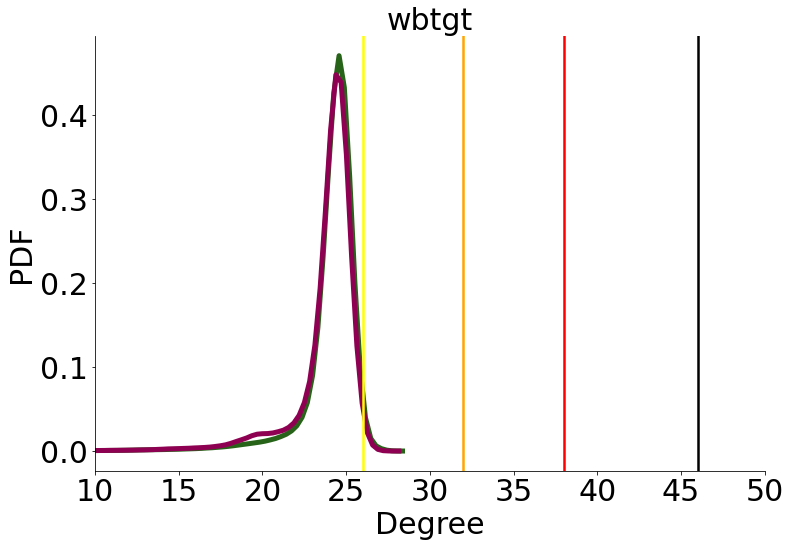

In [62]:
bins = 100
# TASMAX
#pdf_tasmax_ctl, bins_tasmax_ctl = np.histogram(tasmax_ctl_mask_f, bins=bins, density=True)  # Adjust the number of bins as needed
#pdf_tasmax_def, bins_tasmax_def = np.histogram(tasmax_def_mask_f, bins=bins, density=True)
# AT
pdf_at_ctl, bins_at_ctl = np.histogram(wbt_ctl_mask_f, bins=bins, density=True)  # Adjust the number of bins as needed
pdf_at_def, bins_at_def = np.histogram(wbt_def_mask_f, bins=bins, density=True)

# Calculate the bin centers
bin_centers_ctl = (bins_at_ctl[:-1] + bins_at_ctl[1:]) / 2
bin_centers_def = (bins_at_def[:-1] + bins_at_def[1:]) / 2

# Calculate the bin width
bin_width_ctl = np.diff(bin_centers_ctl)
bin_width_def = np.diff(bin_centers_def)

cmap = matplotlib.cm.get_cmap('PiYG')
left = cmap(0.0)
right = cmap(1.0)

# Plot the PDF
fig, ax = plt.subplots(figsize=(12,8))
#TASMAX
#plt.plot(bin_centers_ctl, pdf_tasmax_ctl, label='TASMAX CTL', color=right, linewidth=5)
#plt.plot(bin_centers_def, pdf_tasmax_def, label='TASMAX DEF', color=left, linewidth=5, ls='--')

plt.plot(bin_centers_ctl, pdf_at_ctl, label='HI CTL', color=right, linewidth=5)
plt.plot(bin_centers_def, pdf_at_def, label='HI DEF', color=left, linewidth=5)


# Set labels and title
plt.xlabel('Degree', fontsize='30')
plt.ylabel('PDF', fontsize='30')
#plt.title(title, fontsize='20')
#plt.yscale('log')
plt.xlim(10, 50)

# plot p99
#if p99_1 is not None:
#    plt.axvline(p99_1, color=right, ls=':', linewidth=3.5)
#if p99_2 is not None:
#    plt.axvline(p99_2, color=left, ls=':', linewidth=3.5)

plt.axvline(26, color='yellow', linewidth=2.5)
plt.axvline(32, color='orange', linewidth=2.5)
plt.axvline(38, color='red', linewidth=2.5)
plt.axvline(46, color='black', linewidth=2.5)


plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)

# add legend
#plt.legend(fontsize=30)
plt.title('wbtgt', fontsize=30)
# remove top and right spines
ax.spines[['right', 'top']].set_visible(False)

# Display the plot
plt.show()

# Calculate the percentage of values above the threshold

In [53]:
ctl_data = wbgt_ctl_mask_f
def_data = wbgt_def_mask_f

In [51]:
t1 = 29
t2 = 30.5
t3 = 32
t4 = 37

In [54]:
# Count the frequency of values greater than 10
t1_count_ctl = np.sum(ctl_data > t1)
t1_count_def = np.sum(def_data > t1)

print(t1_count_ctl/len(ctl_data)*100)
print(t1_count_def/len(def_data)*100)

0.22786005574417442
2.3992697120214483


In [55]:
t2_count_ctl = np.sum(ctl_data > t2)
t2_count_def = np.sum(def_data > t2)

print(t2_count_ctl/len(ctl_data)*100)
print(t2_count_def/len(def_data)*100)

0.0011755566035602692
0.0014804815919531472


In [56]:
t3_count_ctl = np.sum(ctl_data > t3)
t3_count_def = np.sum(def_data > t3)

print(t3_count_ctl/len(ctl_data)*100)
print(t3_count_def/len(def_data)*100)

0.0
0.0


In [57]:
t4_count_ctl = np.sum(ctl_data > t4)
t4_count_def = np.sum(def_data > t4)

print(t4_count_ctl/len(ctl_data)*100)
print(t4_count_def/len(def_data)*100)

0.0
0.0


# Box and Whisker Plot

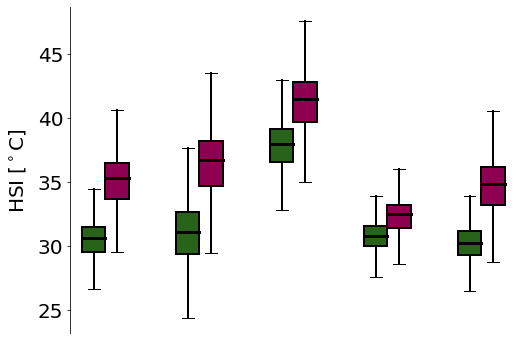

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace this with your actual data)
#data_1 = utci_ctl_mask_f # Random data with negative values for illustration
#data_2 = utci_def_mask_f
#data_1[data_1 == 0] = np.nan  # Mask zeros (use np.nan to ignore during calculations)
#data_2[data_2 == 0] = np.nan  # Mask zeros (use np.nan to ignore during calculations)

# Flatten and filter out NaN (or zeros)
#filtered_data_1 = data_1[~np.isnan(data_1)]
#filtered_data_2 = data_2[~np.isnan(data_2)]

# Plot the box-and-whisker plot
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size
fig.patch.set_alpha(0.0)

data_to_plot = [at_ctl_mask_f, at_def_mask_f, hi_ctl_mask_f, hi_def_mask_f, humidex_ctl_mask_f, humidex_def_mask_f, swbgt_ctl_mask_f, swbgt_def_mask_f, utci_ctl_mask_f, utci_def_mask_f]
positions = [1, 1.5, 3, 3.5, 5, 5.5, 7, 7.5, 9, 9.5]
#ax.boxplot(data_1, vert=True, patch_artist=False, showmeans=False, showfliers=False,
#           boxprops={'color': 'black','linewidth': 2},
      #     flierprops={'marker': 'o','markerfacecolor': 'red','markeredgecolor': 'red','markersize': 5},
#           whiskerprops={'color': 'black','linewidth': 2}, 
#           medianprops={'color': 'black','linewidth': 3})
#ax.boxplot(data_2, vert=True, patch_artist=False, showmeans=False, showfliers=False,
#           boxprops={'color': 'black','linewidth': 2},
      #     flierprops={'marker': 'o','markerfacecolor': 'red','markeredgecolor': 'red','markersize': 5},
#           whiskerprops={'color': 'black','linewidth': 2}, 
#           medianprops={'color': 'black','linewidth': 3})
      #     capprops={'color': 'black','linewidth': 2})
boxplots = ax.boxplot(
    data_to_plot, 
    positions=positions, 
    vert=True, 
    patch_artist=True, 
    showmeans=False, 
    showfliers=False,
    boxprops={'color': 'black', 'linewidth': 2},
    whiskerprops={'color': 'black', 'linewidth': 2},
    medianprops={'color': 'black', 'linewidth': 3}
)

# Change the color of each box
cmap = matplotlib.cm.get_cmap('PiYG')
left = cmap(0.0)
right = cmap(1.0)
colors = [right, left, right, left, right, left, right, left, right, left]  # Define colors for each box
for box, color in zip(boxplots['boxes'], colors):
    box.set_facecolor(color)
    
# Customize the plot
ax.tick_params(axis='y', labelsize=20, colors='black')  # Increase y-axis font size and make it black
ax.tick_params(axis='x', bottom=False, labelbottom=False)  # Hide x-axis ticks and labels

# Y-axis label
ax.set_ylabel('HSI [$^\circ$C]', fontsize=20, color='black', rotation=90, labelpad=20, va='center')

# Remove grid and spines
ax.grid(False)
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)

# Adjust left spine color
ax.spines['left'].set_color('black')

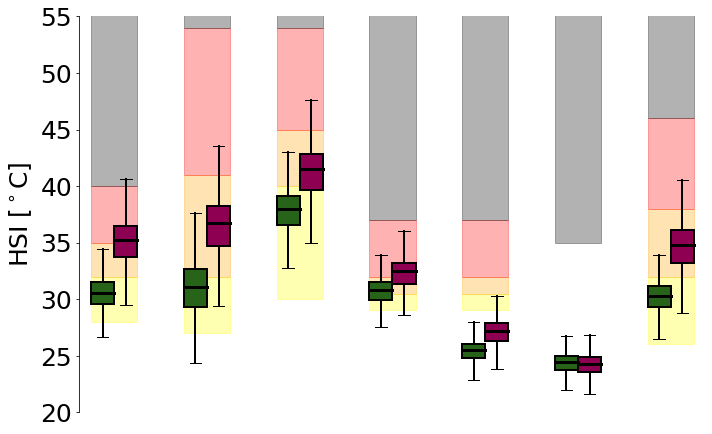

In [41]:
import matplotlib.cm
import matplotlib.pyplot as plt

# Define the data to plot
data_to_plot = [at_ctl_mask_f, at_def_mask_f, hi_ctl_mask_f, hi_def_mask_f, humidex_ctl_mask_f, humidex_def_mask_f, swbgt_ctl_mask_f, swbgt_def_mask_f, wbgt_ctl_mask_f, wbgt_def_mask_f, wbt_ctl_mask_f, wbt_def_mask_f, utci_ctl_mask_f, utci_def_mask_f]

# Define positions with small gaps between pairs
positions = [1, 1.5, 3, 3.5, 5, 5.5, 7, 7.5, 9, 9.5, 11, 11.5, 13, 13.5]
positions_color = [1.25, 3.25, 5.25, 7.25, 9.25, 11.25, 13.25]
# Define ranges and corresponding colors for the background
background_ranges_at = [
    (28, 32, 'yellow'),     # Below 28 to 32
    (32, 35, 'orange'),     # 32 to 35
    (35, 40, 'red'),        # 35 to 40
    (40, 60, 'black')       # Above 40
]
background_ranges_hi = [
    (27, 32, 'yellow'),     # Below 28 to 32
    (32, 41, 'orange'),     # 32 to 35
    (41, 54, 'red'),        # 35 to 40
    (54, 60, 'black')       # Above 40
]
background_ranges_humidex = [
    (30, 40, 'yellow'),     # Below 28 to 32
    (40, 45, 'orange'),     # 32 to 35
    (45, 54, 'red'),        # 35 to 40
    (54, 60, 'black')       # Above 40
]
background_ranges_swbgt = [
    (29, 30.5, 'yellow'),     # Below 28 to 32
    (30.5, 32, 'orange'),     # 32 to 35
    (32, 37, 'red'),        # 35 to 40
    (37, 60, 'black')       # Above 40
]
background_ranges_wbgt = [
    (29, 30.5, 'yellow'),     # Below 28 to 32
    (30.5, 32, 'orange'),     # 32 to 35
    (32, 37, 'red'),        # 35 to 40
    (37, 60, 'black')       # Above 40
]
background_ranges_wbt = [
    (35, 60, 'black')       # Above 40
]
background_ranges_utci = [
    (26, 32, 'yellow'),     # Below 28 to 32
    (32, 38, 'orange'),     # 32 to 35
    (38, 46, 'red'),        # 35 to 40
    (46, 60, 'black')       # Above 40
]

# Plot the box-and-whisker plot
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_alpha(0.0)

boxplots = ax.boxplot(
    data_to_plot, 
    positions=positions, 
    vert=True, 
    patch_artist=True, 
    showmeans=False, 
    showfliers=False,
    boxprops={'color': 'black', 'linewidth': 2},
    whiskerprops={'color': 'black', 'linewidth': 2},
    medianprops={'color': 'black', 'linewidth': 3}
)

# Apply background coloring for each box plot column
#for i, pos in enumerate(positions_color):
#    for ymin, ymax, color in background_ranges:
#        ax.axhspan(ymin, ymax, xmin=(pos - 0.25) / 10, xmax=(pos + 0.25) / 10, color=color, alpha=0.3)
for ymin, ymax, color in background_ranges_at:
    ax.axhspan(ymin, ymax, xmin=(positions[0] - 0.75) / 13.5 , xmax=(positions[0] + 0.25) / 13.5, color=color, alpha=0.3)
for ymin, ymax, color in background_ranges_hi:
    ax.axhspan(ymin, ymax, xmin=(positions[2] - 0.75) / 13.5, xmax=(positions[2] + 0.25) / 13.5, color=color, alpha=0.3)
for ymin, ymax, color in background_ranges_humidex:
    ax.axhspan(ymin, ymax, xmin=(positions[4] - 0.75) / 13.5, xmax=(positions[4] + 0.25) / 13.5, color=color, alpha=0.3)
for ymin, ymax, color in background_ranges_swbgt:    
    ax.axhspan(ymin, ymax, xmin=(positions[6] - 0.75) / 13.5, xmax=(positions[6] + 0.25) / 13.5, color=color, alpha=0.3)
for ymin, ymax, color in background_ranges_wbgt:    
    ax.axhspan(ymin, ymax, xmin=(positions[8] - 0.75) / 13.5, xmax=(positions[8] + 0.25) / 13.5, color=color, alpha=0.3)
for ymin, ymax, color in background_ranges_wbt:    
    ax.axhspan(ymin, ymax, xmin=(positions[10] - 0.75) / 13.5, xmax=(positions[10] + 0.25) / 13.5, color=color, alpha=0.3)
for ymin, ymax, color in background_ranges_utci:
    ax.axhspan(ymin, ymax, xmin=(positions[12] - 0.75) / 13.5, xmax=(positions[12] + 0.25) / 13.5, color=color, alpha=0.3)

# Change the color of each box
cmap = matplotlib.cm.get_cmap('PiYG')
left = cmap(0.0)
right = cmap(1.0)
colors = [right, left, right, left, right, left, right, left, right, left, right, left, right, left]
for box, color in zip(boxplots['boxes'], colors):
    box.set_facecolor(color)

# Customize the plot
ax.tick_params(axis='y', labelsize=25, colors='black')
ax.tick_params(axis='x', bottom=False, labelbottom=False)

# Y-axis label
ax.set_ylabel(r'HSI [$^\circ$C]', fontsize=25, color='black', rotation=90, labelpad=20, va='center')

# Remove grid and spines
ax.grid(False)
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)

# Adjust left spine color
ax.spines['left'].set_color('black')
ax.set_ylim(20, 55)
# Show the plot
plt.tight_layout()
plt.show()
